# CRF sequence tagging for Movie Queries

This project involves optimizing the performance of a **Conditional Random Field (CRF) sequence tagger** for movie trivia questions and answers data, which consist of instances of data of word sequences with the target classes/labels for each word in a **BIO (Beginning, Inside, Outside)** tagging format. 

This project involves reading in, pre-processing, training and developing your tagger on the training data from *trivia10k13train.bio.txt*, and finally testing your tagger on the data *trivia10k13test.bio.txt*, attempting to get the best performing tagger across the different labels in the development process. I will optimize the performance of the tagger by improving its feature extraction function on the word sequences, incorporating POS tagging first, then the final task is to optimize the performance by all legal means neccessary (except looking at the test data).

In [1]:
# You may need to run this first- uncomment if so
!pip install python-crfsuite

In [2]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [3]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

### Task 1. Split the training data into 80% training, 20% development set

In [4]:
#prepare the training data and test data
#Task-1. Split the training data and test data
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 
from sklearn.model_selection import train_test_split
raw_train, raw_test = train_test_split(raw_training_data, test_size=0.2, random_state=42)

In [5]:
#number of instances and words in raw_training_data before spliting
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")


7816 instances
158823 words


In [6]:
#number of instances and words in raw_train
print(len(raw_train), "instances")
print(sum([len(sent) for sent in raw_train]), "words")

6252 instances
126934 words


In [7]:
#number of instances and words in raw_test
print(len(raw_test), "instances")
print(sum([len(sent) for sent in raw_test]), "words")

1564 instances
31889 words


In [8]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [9]:
training_data = [preProcess(example) for example in raw_train]

In [10]:
# check the effect of pre-processing
print(training_data[0:2])

[[('what', 'O'), ('is', 'O'), ('the', 'O'), ('name', 'O'), ('of', 'O'), ('one', 'O'), ('of', 'O'), ('paul', 'B-Actor'), ('rudd', 'I-Actor'), ('s', 'O'), ('latest', 'O'), ('movies', 'O'), ('that', 'O'), ('is', 'O'), ('a', 'O'), ('comedy', 'B-Genre'), ('and', 'O'), ('deals', 'B-Plot'), ('with', 'I-Plot'), ('age', 'I-Plot')], [('what', 'O'), ('2012', 'B-Year'), ('movie', 'O'), ('features', 'O'), ('a', 'O'), ('struggling', 'B-Plot'), ('screenwriter', 'I-Plot'), ('who', 'I-Plot'), ('gets', 'I-Plot'), ('caught', 'I-Plot'), ('up', 'I-Plot'), ('in', 'I-Plot'), ('the', 'I-Plot'), ('los', 'I-Plot'), ('angeles', 'I-Plot'), ('criminal', 'I-Plot'), ('underworld', 'I-Plot')]]


In [11]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [12]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [13]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = raw_test 
#raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1564 instances
31889 words


In [14]:
#testing the model 
# add 'words' variable to input all the words in the test-data for later evaluation of FP and FN
print("testing tagger...")
preds = []
y_test = []
words = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    word = [x[0] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    words.extend(word)
print("done")

testing tagger...
done


In [15]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

C:\Users\dandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.87      0.88      0.87       967
         B-Award       0.79      0.60      0.68        62
B-Character_Name       0.75      0.24      0.36       217
      B-Director       0.79      0.69      0.73       357
         B-Genre       0.81      0.72      0.76       684
       B-Opinion       0.40      0.28      0.33       165
        B-Origin       0.53      0.33      0.41       157
          B-Plot       0.48      0.44      0.46      1321
         B-Quote       0.22      0.11      0.14        19
  B-Relationship       0.75      0.45      0.56       134
    B-Soundtrack       0.00      0.00      0.00        11
          B-Year       0.96      0.96      0.96       500
         I-Actor       0.87      0.87      0.87      1179
         I-Award       0.72      0.78      0.75       124
I-Character_Name       0.65      0.26      0.37       141
      I-Director       0.83      0.70      0.76       316
         I-Ge

C:\Users\dandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
#Define a function to convert classification report to dataframe
#in oder to fetch the lowest 5 classes in precision later on
import pandas as pd
def classi_rpt_to_df(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:27]:
        row = {}
        row_data = line.split("     ")
        row['class'] = row_data[-5]
        row['precision'] = float(row_data[-4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)

    return dataframe

In [17]:
#Output the lowest 5 classes in precision
report = classification_report(y_test, preds)
#df_report = classi_rpt_to_df(report)
df_report = classi_rpt_to_df(report).sort_values(by=['precision'])
list1 = df_report.iloc[0:5,0].replace(" ","").tolist()
print("The precision in ascending order: \n", df_report)
print("the 5 lowest classes in precision are:")
display(list1)

C:\Users\dandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The precision in ascending order: 
                class  precision
10      B-Soundtrack       0.00
22      I-Soundtrack       0.00
17         I-Opinion       0.12
8            B-Quote       0.22
20           I-Quote       0.24
5          B-Opinion       0.40
7             B-Plot       0.48
6           B-Origin       0.53
21    I-Relationship       0.57
18          I-Origin       0.63
14  I-Character_Name       0.65
23            I-Year       0.70
13           I-Award       0.72
9     B-Relationship       0.75
2   B-Character_Name       0.75
16           I-Genre       0.76
3         B-Director       0.79
1            B-Award       0.79
4            B-Genre       0.81
15        I-Director       0.83
19            I-Plot       0.83
0            B-Actor       0.87
12           I-Actor       0.87
24                 O       0.87
11            B-Year       0.96
the 5 lowest classes in precision are:


C:\Users\dandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['    B-Soundtrack',
 '    I-Soundtrack',
 '  I-Opinion',
 '    B-Quote',
 '    I-Quote']

In [18]:
#Task 2. False Positive Errors Analysis
for i in range(len(y_test)):
    low_prec_class = ("B-Soundtrack","I-Soundtrack","I-Opinion","B-Quote","I-Quote")
    for x in low_prec_class:
        if (preds[i] == x) & (preds[i] != y_test[i]):
                print("False Positive words:", words[i], "=> Prediction:", preds[i], "=> True label:", y_test[i],"\n")

False Positive words: how => Prediction: B-Quote => True label: B-Plot 

False Positive words: you => Prediction: I-Quote => True label: I-Plot 

False Positive words: ca => Prediction: I-Quote => True label: I-Plot 

False Positive words: n => Prediction: I-Quote => True label: I-Plot 

False Positive words: t => Prediction: I-Quote => True label: I-Plot 

False Positive words: cheat => Prediction: I-Quote => True label: I-Plot 

False Positive words: death => Prediction: I-Quote => True label: I-Plot 

False Positive words: or => Prediction: I-Quote => True label: I-Plot 

False Positive words: fate => Prediction: I-Quote => True label: I-Plot 

False Positive words: war => Prediction: I-Opinion => True label: B-Genre 

False Positive words: purcell => Prediction: I-Opinion => True label: I-Actor 

False Positive words: dc => Prediction: I-Opinion => True label: I-Origin 

False Positive words: comic => Prediction: I-Opinion => True label: I-Origin 

False Positive words: made => Pre

In [19]:
#Q3. False Negative Errors Analysis
for i in range(len(y_test)):
    low_prec_class = ("B-Soundtrack","I-Soundtrack","I-Opinion","B-Quote","I-Quote")
    for x in low_prec_class:
        if (y_test[i] == x) & (preds[i] != y_test[i]):
                print("False Negative words:", words[i], "=> true label:", y_test[i], "=> prediction:", preds[i], "\n")

False Negative words: a => true label: B-Quote => prediction: B-Plot 

False Negative words: clue => true label: I-Quote => prediction: I-Plot 

False Negative words: a => true label: I-Quote => prediction: I-Plot 

False Negative words: clue => true label: I-Quote => prediction: I-Plot 

False Negative words: my => true label: I-Quote => prediction: I-Plot 

False Negative words: kingdom => true label: I-Quote => prediction: I-Plot 

False Negative words: for => true label: I-Quote => prediction: I-Plot 

False Negative words: a => true label: I-Quote => prediction: I-Plot 

False Negative words: clue => true label: I-Quote => prediction: I-Plot 

False Negative words: popular => true label: I-Opinion => prediction: O 

False Negative words: idolized => true label: I-Opinion => prediction: O 

False Negative words: favorite => true label: I-Opinion => prediction: I-Genre 

False Negative words: god => true label: B-Quote => prediction: B-Plot 

False Negative words: lay => true label:

In [20]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(25,25))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

C:\Users\dandi\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['I-Plot', 'I-Year', 'I-Genre', 'I-Quote', 'B-Genre', 'I-Origin', 'B-Relationship', 'I-Director', 'I-Opinion', 'B-Director', 'I-Relationship', 'B-Year', 'B-Plot', 'O', 'B-Actor', 'B-Origin', 'B-Soundtrack', 'I-Soundtrack', 'I-Award', 'B-Character_Name', 'B-Opinion', 'B-Quote', 'B-Award', 'I-Character_Name', 'I-Actor'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


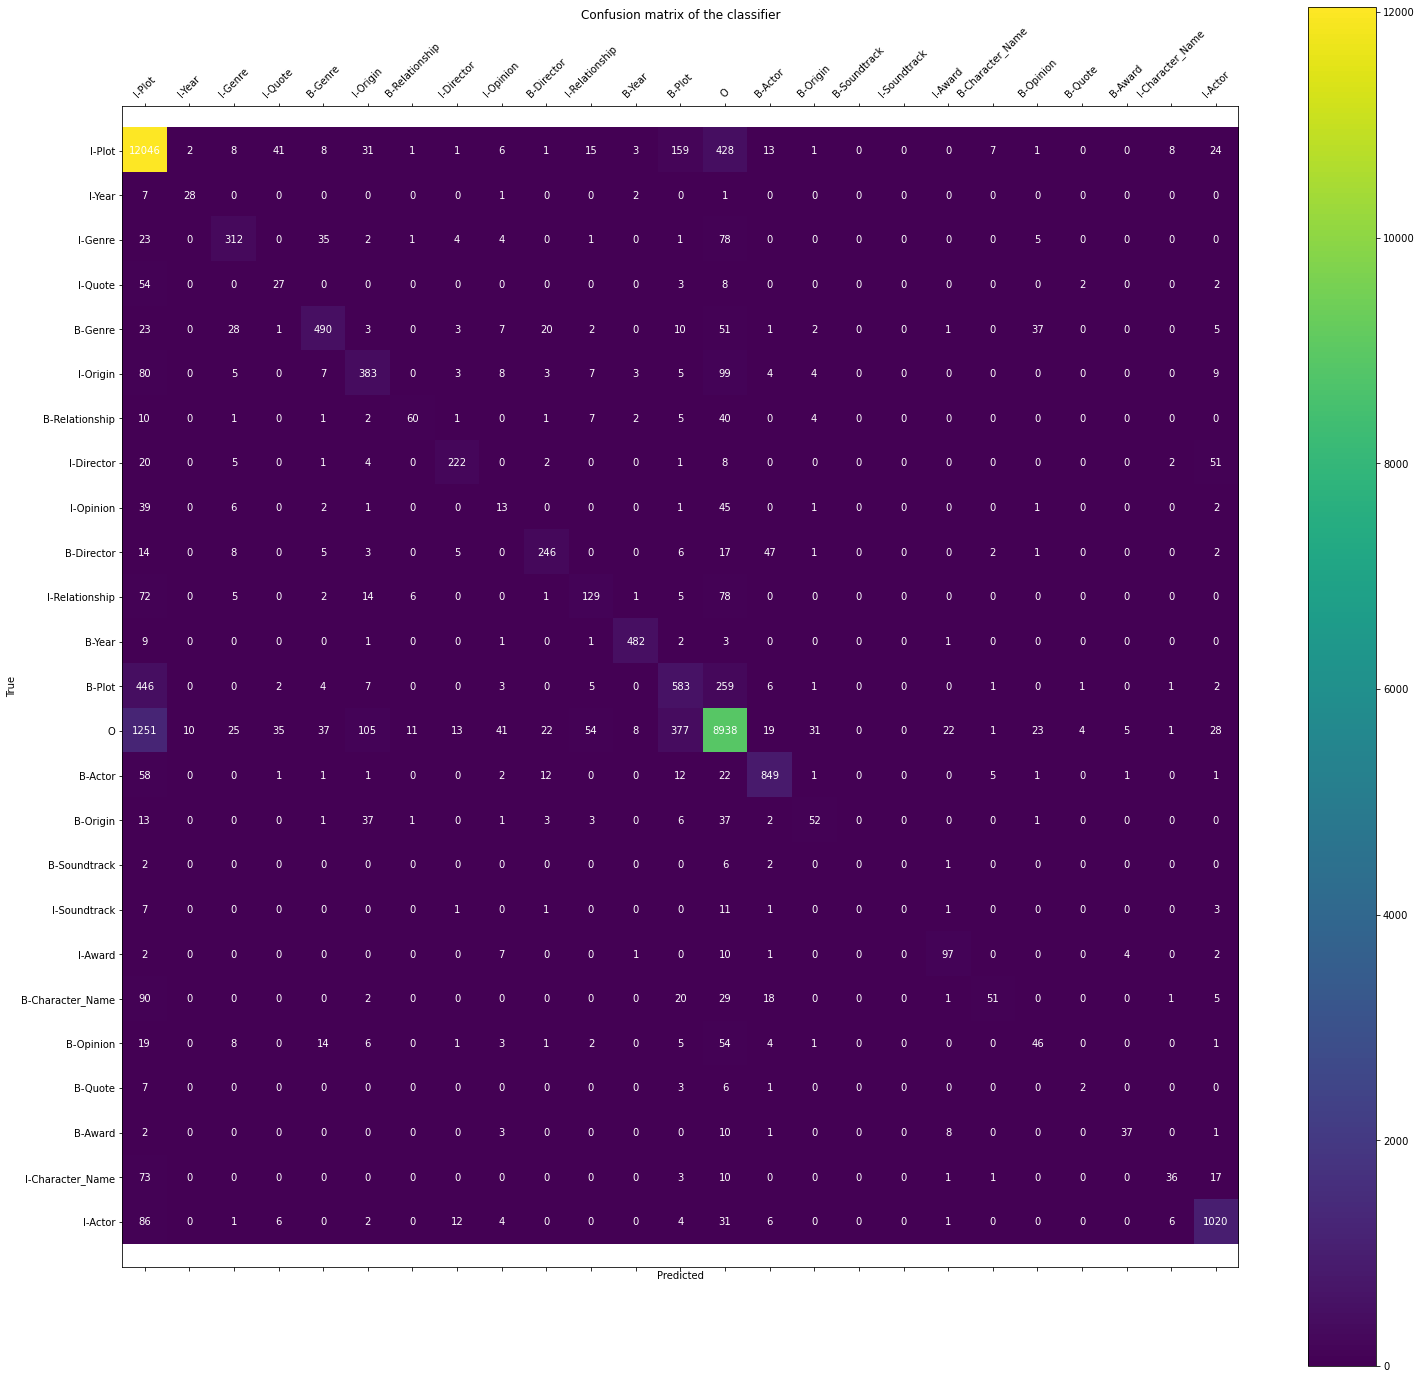

In [21]:
confusion_matrix_heatmap(y_test, preds)

In [22]:
# Let's see what the CRF learned by looking at the internal transition/feature weights....

In [23]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [24]:
print_transition_weights(ct._tagger.info().transitions.items())

8.475298 B-Actor  -> I-Actor
8.092959 B-Plot   -> I-Plot
7.858381 B-Director -> I-Director
7.536256 B-Origin -> I-Origin
7.521705 I-Plot   -> I-Plot
7.362154 I-Quote  -> I-Quote
7.288524 B-Character_Name -> I-Character_Name
7.145376 I-Origin -> I-Origin
7.023769 B-Relationship -> I-Relationship
6.897642 B-Quote  -> I-Quote
6.813574 I-Relationship -> I-Relationship
6.700214 I-Soundtrack -> I-Soundtrack
6.660951 I-Opinion -> I-Opinion
6.529798 B-Genre  -> I-Genre
6.371417 B-Award  -> I-Award
6.269689 I-Award  -> I-Award
6.235901 B-Soundtrack -> I-Soundtrack
6.164277 B-Opinion -> I-Opinion
6.155905 I-Genre  -> I-Genre
6.129352 I-Actor  -> I-Actor
6.019243 I-Character_Name -> I-Character_Name
5.209142 I-Director -> I-Director
4.608661 I-Year   -> I-Year
3.848042 B-Year   -> I-Year
3.679927 B-Character_Name -> B-Plot
3.517446 O        -> O
3.304645 I-Character_Name -> B-Plot
3.229043 O        -> B-Plot
2.950265 B-Opinion -> B-Genre
2.944658 O        -> B-Character_Name
2.919887 B-Plot   -> 

In [25]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)  # assume we want to print all of them
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    for (attr, label), weight in ranked_state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [26]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

5.159804 B-Year   HAS_NUM
4.253509 I-Year   WORD_s
4.128803 B-Genre  WORD_animated
2.988575 B-Genre  WORD_thriller
2.899423 B-Genre  WORD_action
2.790667 B-Plot   WORD_a
2.722021 I-Genre  WORD_animated
2.717949 B-Quote  WORD_i
2.717136 B-Opinion WORD_blockbuster
2.624115 B-Relationship SUF_uel
2.568342 B-Award  WORD_oscar
2.495351 B-Genre  WORD_animation
2.465141 B-Director WORD_disney
2.456028 B-Award  SUF_car
2.365012 B-Relationship WORD_remake
2.347775 B-Relationship WORD_sequel
2.294816 I-Genre  WORD_fiction
2.294273 I-Genre  WORD_white
2.274617 B-Genre  WORD_comedy
2.236883 B-Genre  WORD_horror
2.235675 B-Opinion WORD_masterpiece
2.226258 B-Plot   WORD_an
2.215164 B-Genre  WORD_musical
2.190119 B-Genre  WORD_war
2.179582 B-Genre  WORD_crime
2.160229 I-Origin WORD_by
2.159432 B-Actor  WORD_cher
2.139885 B-Director SUF_xar
2.139885 B-Director WORD_pixar
2.138859 I-Genre  WORD_thriller
2.120818 B-Genre  WORD_slasher
2.106633 B-Character_Name WORD_dave
2.103492 B-Award  WORD_won
2.092

In [21]:
#Task 4.newly changed preprocess() function to display 'word@POStag'
def preProcess(example):
    current_sent = []
    word_POStag_join_total = []
    NERtag = []
    NERtag_final = []
    final_2 = []
    for i in range(len(example)):
        posttagger = CRFTagger()
        posttagger.set_model_file("crf_pos.tagger")
        current_sent.append(example[i][0])
        word_POStag = posttagger.tag(current_sent)
        word_POStag_join = word_POStag[i][0]+"@"+word_POStag[i][1]
        word_POStag_join_total.append(word_POStag_join)
        
        NERtag = example[i][1]
        NERtag_final.append(NERtag)
        final = (word_POStag_join_total[i],NERtag_final[i])
        final_2.append(final)
    return final_2

In [22]:
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
# example use:
words = ["what", "is", "the", "and", "bill"]
print(posttagger.tag(words))

[('what', 'WP'), ('is', 'VBZ'), ('the', 'DT'), ('and', 'CC'), ('bill', 'NN')]


In [23]:
training_data = [preProcess(example) for example in raw_train]

In [24]:
#verify the number of instances for 'training_data'
len(training_data)

6252

In [25]:
# check the effect of pre-processing
print(training_data[0:2])

[[('what@WP', 'O'), ('is@VBZ', 'O'), ('the@DT', 'O'), ('name@NN', 'O'), ('of@IN', 'O'), ('one@CD', 'O'), ('of@IN', 'O'), ('paul@NNP', 'B-Actor'), ('rudd@NNP', 'I-Actor'), ('s@NNP', 'O'), ('latest@JJS', 'O'), ('movies@NNS', 'O'), ('that@WDT', 'O'), ('is@VBZ', 'O'), ('a@DT', 'O'), ('comedy@NN', 'B-Genre'), ('and@CC', 'O'), ('deals@NNS', 'B-Plot'), ('with@IN', 'I-Plot'), ('age@NN', 'I-Plot')], [('what@WP', 'O'), ('2012@VBP', 'B-Year'), ('movie@NN', 'O'), ('features@NNS', 'O'), ('a@DT', 'O'), ('struggling@VBG', 'B-Plot'), ('screenwriter@NN', 'I-Plot'), ('who@WP', 'I-Plot'), ('gets@VBZ', 'I-Plot'), ('caught@VBN', 'I-Plot'), ('up@RP', 'I-Plot'), ('in@IN', 'I-Plot'), ('the@DT', 'I-Plot'), ('los@NNS', 'I-Plot'), ('angeles@NNP', 'I-Plot'), ('criminal@NNP', 'I-Plot'), ('underworld@NNP', 'I-Plot')]]


In [26]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

#Task 4. add tags to output features in the form of (assume 'NN' is the POStag here) '[feature1,feature2...,POStag_NN]'
# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    #print (tokens)
    #print (idx)
    
    token = tokens[idx]
    feature_list = []
    tag = token.split("@")[1]
    token = token.split("@")[0]


    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    feature_list.append("POStag_" + tag)
    #print(feature_list)
    return feature_list

In [27]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [28]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = raw_test 
#raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1564 instances
31889 words


In [29]:
print("testing tagger...")
preds = []
y_test = []
words = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    word = [x[0] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    words.extend(word)
print("done")

testing tagger...
done


In [30]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

C:\Users\dandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.86      0.89      0.88       967
         B-Award       0.79      0.60      0.68        62
B-Character_Name       0.65      0.25      0.37       217
      B-Director       0.78      0.68      0.73       357
         B-Genre       0.82      0.72      0.77       684
       B-Opinion       0.42      0.29      0.34       165
        B-Origin       0.54      0.35      0.42       157
          B-Plot       0.49      0.45      0.47      1321
         B-Quote       0.45      0.26      0.33        19
  B-Relationship       0.76      0.44      0.56       134
    B-Soundtrack       0.00      0.00      0.00        11
          B-Year       0.96      0.97      0.96       500
         I-Actor       0.86      0.90      0.88      1179
         I-Award       0.71      0.79      0.75       124
I-Character_Name       0.56      0.29      0.38       141
      I-Director       0.83      0.70      0.76       316
         I-Ge

C:\Users\dandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
#put the report in dataframe and sort the precision in ascending order
report = classification_report(y_test, preds)
df_report = classi_rpt_to_df(report).sort_values(by=['precision'])
list1 = df_report.iloc[0:5,0].replace(" ","").tolist()
print("The precision in ascending order: \n", df_report)
print("the 5 lowest classes in precision are:")
display(list1)

C:\Users\dandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The precision in ascending order: 
                class  precision
10      B-Soundtrack       0.00
22      I-Soundtrack       0.00
17         I-Opinion       0.22
20           I-Quote       0.40
5          B-Opinion       0.42
8            B-Quote       0.45
7             B-Plot       0.49
6           B-Origin       0.54
14  I-Character_Name       0.56
21    I-Relationship       0.56
18          I-Origin       0.63
2   B-Character_Name       0.65
13           I-Award       0.71
23            I-Year       0.72
16           I-Genre       0.76
9     B-Relationship       0.76
3         B-Director       0.78
1            B-Award       0.79
4            B-Genre       0.82
15        I-Director       0.83
19            I-Plot       0.84
0            B-Actor       0.86
12           I-Actor       0.86
24                 O       0.87
11            B-Year       0.96
the 5 lowest classes in precision are:


C:\Users\dandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['    B-Soundtrack',
 '    I-Soundtrack',
 '  I-Opinion',
 '    I-Quote',
 '  B-Opinion']

C:\Users\dandi\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['I-Plot', 'B-Director', 'I-Year', 'I-Opinion', 'I-Quote', 'B-Quote', 'B-Relationship', 'I-Soundtrack', 'B-Award', 'B-Soundtrack', 'I-Character_Name', 'I-Director', 'B-Genre', 'B-Character_Name', 'B-Origin', 'B-Plot', 'I-Genre', 'I-Award', 'O', 'B-Opinion', 'I-Origin', 'B-Actor', 'B-Year', 'I-Actor', 'I-Relationship'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


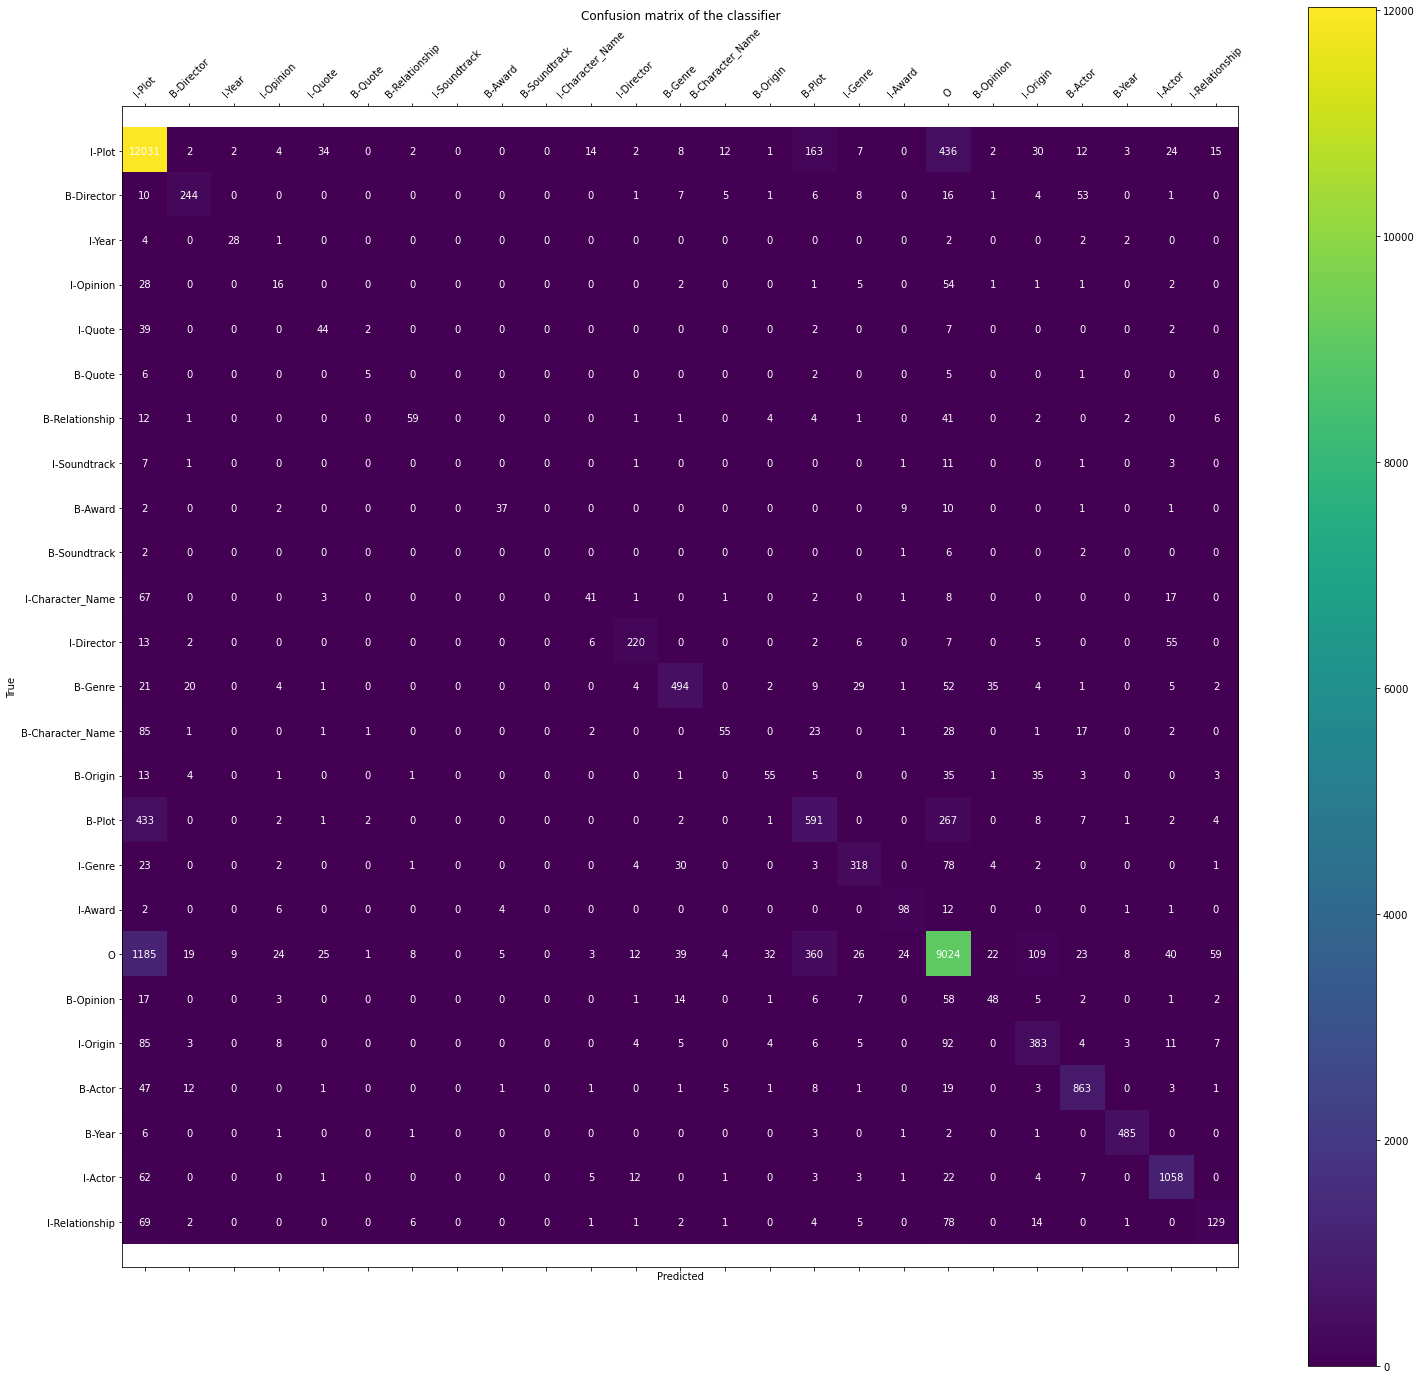

In [32]:
confusion_matrix_heatmap(y_test, preds)

# Experiement different features:

In [33]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [34]:
from sklearn.model_selection import train_test_split
raw_train, raw_heldout = train_test_split(raw_training_data, test_size=0.2, random_state=42)

In [35]:
#number of instances and words in raw_train
print(len(raw_train), "instances")
print(sum([len(sent) for sent in raw_train]), "words")

6252 instances
126934 words


In [36]:
#number of instances and words in raw_heldout
print(len(raw_heldout), "instances")
print(sum([len(sent) for sent in raw_heldout]), "words")

1564 instances
31889 words


In [37]:
#preprocess() function to display 'word@POStag'
def preProcess(example):
    current_sent = []
    word_POStag_join_total = []
    NERtag = []
    NERtag_final = []
    final_2 = []
    for i in range(len(example)):
        posttagger = CRFTagger()
        posttagger.set_model_file("crf_pos.tagger")
        current_sent.append(example[i][0])
        word_POStag = posttagger.tag(current_sent)
        word_POStag_join = word_POStag[i][0]+"@"+word_POStag[i][1]
        word_POStag_join_total.append(word_POStag_join)
        
        NERtag = example[i][1]
        NERtag_final.append(NERtag)
        final = (word_POStag_join_total[i],NERtag_final[i])
        final_2.append(final)
    return final_2

In [38]:
training_data = [preProcess(example) for example in raw_train]

In [39]:
# check the effect of pre-processing
print(training_data[0:2])

[[('what@WP', 'O'), ('is@VBZ', 'O'), ('the@DT', 'O'), ('name@NN', 'O'), ('of@IN', 'O'), ('one@CD', 'O'), ('of@IN', 'O'), ('paul@NNP', 'B-Actor'), ('rudd@NNP', 'I-Actor'), ('s@NNP', 'O'), ('latest@JJS', 'O'), ('movies@NNS', 'O'), ('that@WDT', 'O'), ('is@VBZ', 'O'), ('a@DT', 'O'), ('comedy@NN', 'B-Genre'), ('and@CC', 'O'), ('deals@NNS', 'B-Plot'), ('with@IN', 'I-Plot'), ('age@NN', 'I-Plot')], [('what@WP', 'O'), ('2012@VBP', 'B-Year'), ('movie@NN', 'O'), ('features@NNS', 'O'), ('a@DT', 'O'), ('struggling@VBG', 'B-Plot'), ('screenwriter@NN', 'I-Plot'), ('who@WP', 'I-Plot'), ('gets@VBZ', 'I-Plot'), ('caught@VBN', 'I-Plot'), ('up@RP', 'I-Plot'), ('in@IN', 'I-Plot'), ('the@DT', 'I-Plot'), ('los@NNS', 'I-Plot'), ('angeles@NNP', 'I-Plot'), ('criminal@NNP', 'I-Plot'), ('underworld@NNP', 'I-Plot')]]


In [40]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
# Add more features to optimize the model
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    #print (tokens)
    #print (idx)
    
    token_pos = tokens[idx]
    feature_list = []
    tag = token_pos.split("@")[1]
    token = token_pos.split("@")[0]


    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 5
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
    if len(token) > 4:
        feature_list.append("SUF_" + token[-4:])
    #if len(token) > 5:
        #feature_list.append("SUF_" + token[-5:])
        
    feature_list.append("WORD_" + token)
    
    #POS tag
    feature_list.append("POStag_" + tag)
    
    #previous 2 words wi-1,wi-2
    if idx>0:
        feature_list.append("wi-1Word_" + tokens[idx-1].split("@")[0])
        if idx>1:
            feature_list.append("wi-2Word_" + tokens[idx-2].split("@")[0])
            
    #previous 2 POS tag
    if idx>0:
        feature_list.append("wi-1POStag_" + tokens[idx-1].split("@")[1])
        #if idx>1:
            #feature_list.append("wi-2POStag_" + tokens[idx-2].split("@")[1])
            
    # next 2 words wi+1,wi+2
    if idx+1 <= len(tokens)-1:
        feature_list.append("wi+1Word_" + tokens[idx+1].split("@")[0])
    #if idx+2 <= len(tokens)-1:
        #feature_list.append("wi+2Word_" + tokens[idx+2].split("@")[0])    
        
    #next 2 word's POS tag
    if idx+1 <= len(tokens)-1:
        feature_list.append("wi+1POStag_" + tokens[idx+1].split("@")[1])
    #if idx+2 <= len(tokens)-1:
        #feature_list.append("wi+2POStag_" + tokens[idx+2].split("@")[1])
        
    #print(feature_list)
    return feature_list

In [41]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":4})
#ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
#ct.train(test3, TAGGER_PATH)
print("done")

training tagger...
done


In [42]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":4})  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_heldout_data = raw_heldout 
#raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
heldout_data = [preProcess(example) for example in raw_heldout_data]
print(len(heldout_data), "instances")
print(sum([len(sent) for sent in heldout_data]), "words")

1564 instances
31889 words


In [43]:
print("testing tagger...")
preds = []
y_heldout = []
words = []
for sent in heldout_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    word = [x[0] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_heldout.extend(sent_true)
    words.extend(word)
print("done")

testing tagger...
done


In [44]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_heldout, preds))
print(precision_recall_fscore_support(y_heldout, preds, average='macro'))  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.93      0.93      0.93       967
         B-Award       0.75      0.61      0.67        62
B-Character_Name       0.77      0.42      0.55       217
      B-Director       0.82      0.81      0.82       357
         B-Genre       0.81      0.75      0.78       684
       B-Opinion       0.49      0.40      0.44       165
        B-Origin       0.53      0.39      0.45       157
          B-Plot       0.51      0.46      0.48      1321
         B-Quote       0.75      0.47      0.58        19
  B-Relationship       0.71      0.48      0.57       134
    B-Soundtrack       1.00      0.45      0.62        11
          B-Year       0.97      0.97      0.97       500
         I-Actor       0.92      0.93      0.93      1179
         I-Award       0.75      0.86      0.80       124
I-Character_Name       0.66      0.43      0.52       141
      I-Director       0.87      0.84      0.85       316
         I-Ge

In [45]:
#define a funcation to convert classification report to dataframe
import pandas as pd
def classi_rpt_to_df(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:27]:
        row = {}
        row_data = line.split("     ")
        row['class'] = row_data[-5]
        row['precision'] = float(row_data[-4])
        #row['recall'] = float(row_data[3])
        #row['f1_score'] = float(row_data[6])
        #row['support'] = float(row_data[7])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    #dataframe.to_csv('classification_report.csv', index = False)
    return dataframe

In [46]:
#put the report in dataframe and sort the precision in ascending order
report = classification_report(y_heldout, preds)
df_report = classi_rpt_to_df(report).sort_values(by=['precision'])
list1 = df_report.iloc[0:5,0].replace(" ","").tolist()
print("The precision in ascending order: \n", df_report)
print("the 5 lowest classes in precision are:")
display(list1)

The precision in ascending order: 
                class  precision
17         I-Opinion       0.30
20           I-Quote       0.43
5          B-Opinion       0.49
7             B-Plot       0.51
21    I-Relationship       0.52
6           B-Origin       0.53
14  I-Character_Name       0.66
18          I-Origin       0.68
9     B-Relationship       0.71
23            I-Year       0.74
13           I-Award       0.75
8            B-Quote       0.75
1            B-Award       0.75
2   B-Character_Name       0.77
16           I-Genre       0.77
4            B-Genre       0.81
3         B-Director       0.82
24                 O       0.87
15        I-Director       0.87
19            I-Plot       0.88
12           I-Actor       0.92
0            B-Actor       0.93
11            B-Year       0.97
10      B-Soundtrack       1.00
22      I-Soundtrack       1.00
the 5 lowest classes in precision are:


['  I-Opinion', '    I-Quote', '  B-Opinion', 'B-Plot', '  I-Relationship']

C:\Users\dandi\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['I-Plot', 'B-Director', 'I-Year', 'I-Opinion', 'I-Quote', 'B-Quote', 'B-Relationship', 'I-Soundtrack', 'B-Award', 'B-Soundtrack', 'I-Character_Name', 'I-Director', 'B-Genre', 'B-Character_Name', 'B-Origin', 'B-Plot', 'I-Genre', 'I-Award', 'O', 'B-Opinion', 'I-Origin', 'B-Actor', 'B-Year', 'I-Actor', 'I-Relationship'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


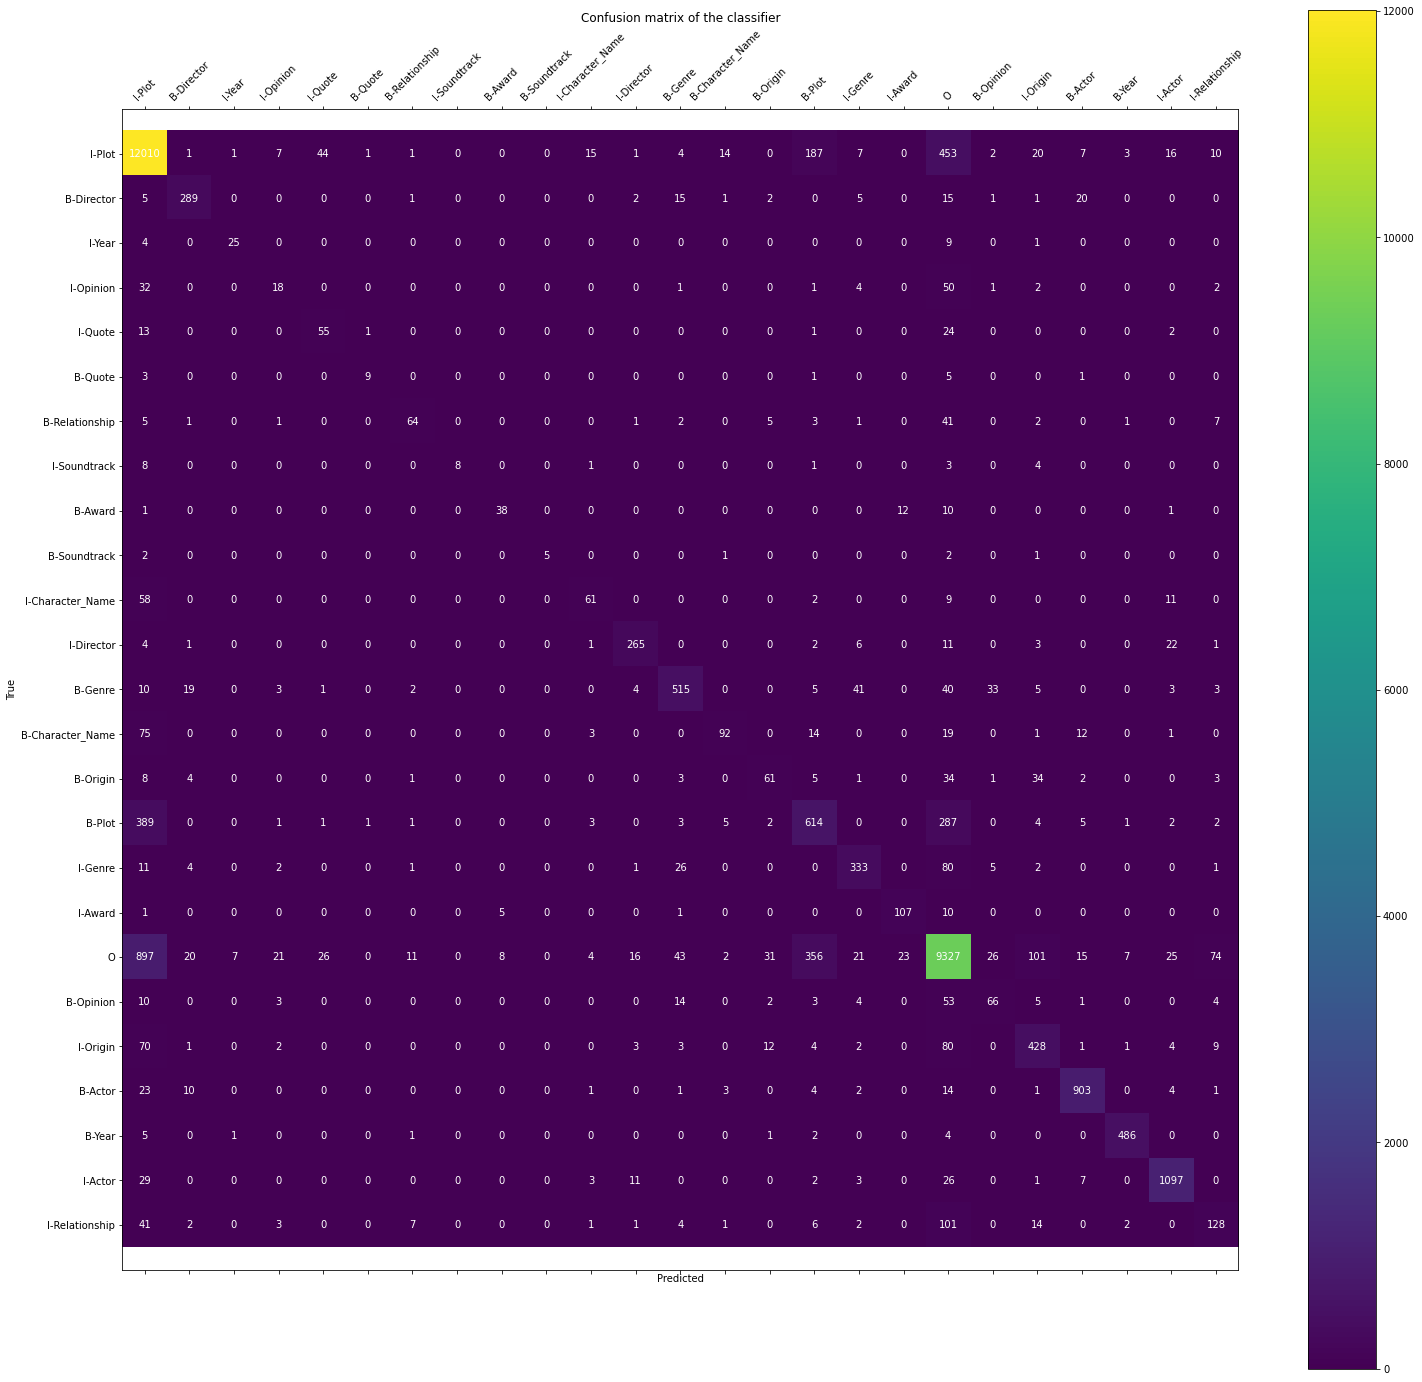

In [47]:
confusion_matrix_heatmap(y_heldout, preds)

# Final results:

In [48]:
# Final results on original test data, using all training data, with best settings:

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print("test_data details:")
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

#prepare training data:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 
raw_train = raw_training_data
training_data = [preProcess(example) for example in raw_train]
#number of instances and words in training data
print("training_data details:")
print(len(training_data), "instances")
print(sum([len(sent) for sent in training_data]), "words")


# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":4})  # initialize tagger with get_features function
print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":4})  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

#testing the model on all testing data
print("testing tagger...")
preds = []
y_test = []
words = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    word = [x[0] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    words.extend(word)
print("done")


test_data details:
1953 instances
39035 words
training_data details:
7816 instances
158823 words
training tagger...
done
testing tagger...
done


In [49]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

C:\Users\dandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93      1274
         B-Award       0.73      0.70      0.71        66
B-Character_Name       0.74      0.40      0.52       283
      B-Director       0.86      0.86      0.86       425
         B-Genre       0.83      0.80      0.81       789
       B-Opinion       0.44      0.31      0.37       195
        B-Origin       0.47      0.37      0.42       190
          B-Plot       0.52      0.50      0.51      1577
         B-Quote       0.89      0.34      0.49        47
  B-Relationship       0.81      0.56      0.66       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.96      0.97      0.97       661
         I-Actor       0.92      0.94      0.93      1553
         I-Award       0.74      0.75      0.75       147
I-Character_Name       0.74      0.48      0.58       227
      I-Director       0.92      0.87      0.89       411
         I-Ge

C:\Users\dandi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\dandi\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['I-Plot', 'B-Director', 'I-Year', 'I-Opinion', 'I-Quote', 'B-Quote', 'B-Relationship', 'I-Soundtrack', 'B-Award', 'B-Soundtrack', 'I-Character_Name', 'I-Director', 'B-Genre', 'B-Character_Name', 'B-Origin', 'B-Plot', 'I-Genre', 'I-Award', 'O', 'B-Opinion', 'I-Origin', 'B-Actor', 'B-Year', 'I-Actor', 'I-Relationship'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


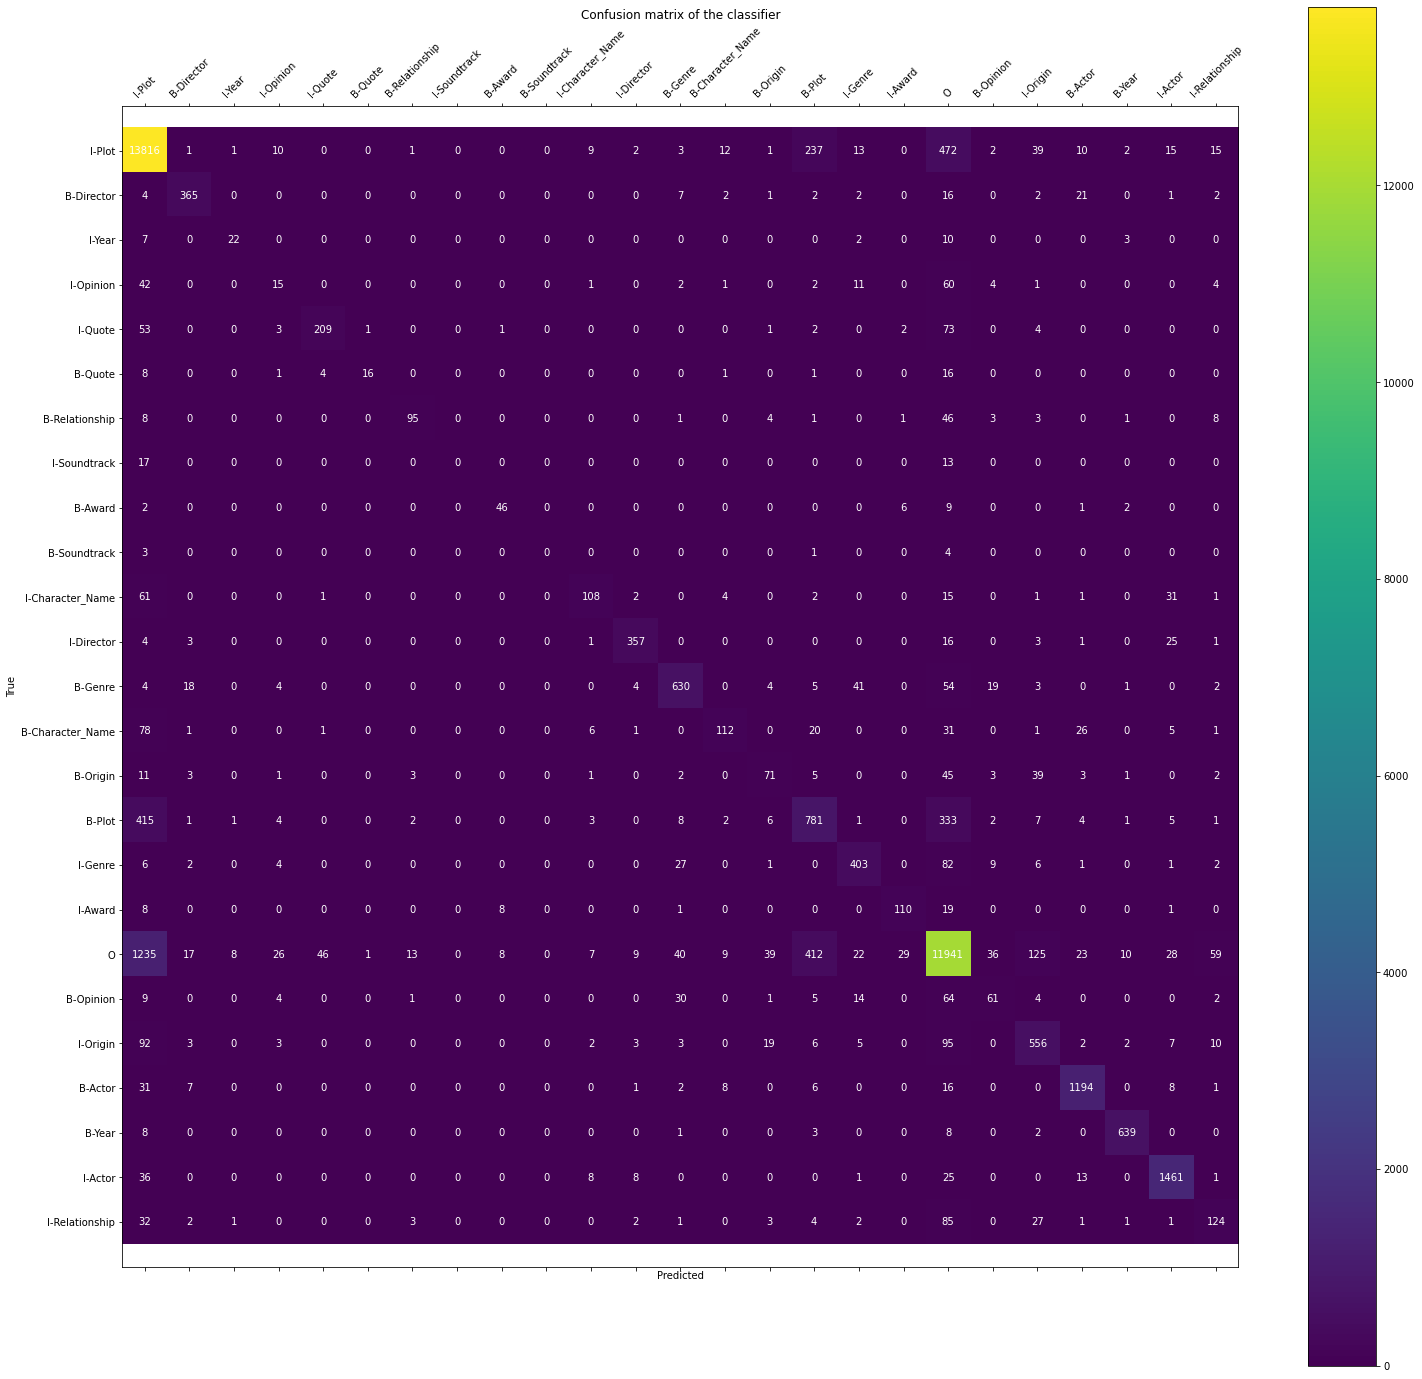

In [50]:
confusion_matrix_heatmap(y_test, preds)